<div class="devsite-table-wrapper"><table class="tfo-notebook-buttons" align="left">
<td><a target="_blank" href="https://www.tensorflow.org/tfx/tutorials/transform/census">
<img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a></td>
<td><a target="_blank" href="https://colab.sandbox.google.com/github/tensorflow/tfx/blob/master/docs/tutorials/transform/census.ipynb">
<img src="https://www.tensorflow.org/images/colab_logo_32px.png">Run in Google Colab</a></td>
<td><a target="_blank" href="https://github.com/tensorflow/tfx/blob/master/docs/tutorials/transform/census.ipynb">
<img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">View source on GitHub</a></td>
<td><a target="_blank" href="https://storage.googleapis.com/tensorflow_docs/tfx/docs/tutorials/transform/census.ipynb">
<img width=32px src="https://www.tensorflow.org/images/download_logo_32px.png">Download notebook</a></td>
</table></div>

##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Preprocessing data with TensorFlow Transform
***The Feature Engineering Component of TensorFlow Extended (TFX)***

This example colab notebook provides a somewhat more advanced example of how <a target='_blank' href='https://www.tensorflow.org/tfx/transform/get_started'>TensorFlow Transform</a> (`tf.Transform`) can be used to preprocess data using exactly the same code for both training a model and serving inferences in production.

TensorFlow Transform is a library for preprocessing input data for TensorFlow, including creating features that require a full pass over the training dataset.  For example, using TensorFlow Transform you could:

* Normalize an input value by using the mean and standard deviation
* Convert strings to integers by generating a vocabulary over all of the input values
* Convert floats to integers by assigning them to buckets, based on the observed data distribution

TensorFlow has built-in support for manipulations on a single example or a batch of examples. `tf.Transform` extends these capabilities to support full passes over the entire training dataset.

The output of `tf.Transform` is exported as a TensorFlow graph which you can use for both training and serving. Using the same graph for both training and serving can prevent skew, since the same transformations are applied in both stages.

Key Point: In order to understand `tf.Transform` and how it works with Apache Beam, you'll need to know a little bit about Apache Beam itself.  The <a target='_blank' href='https://beam.apache.org/documentation/programming-guide/'>Beam Programming Guide</a> is a great place to start.

##What we're doing in this example

In this example we'll be processing a <a target='_blank' href='https://archive.ics.uci.edu/ml/machine-learning-databases/adult'>widely used dataset containing census data</a>, and training a model to do classification.  Along the way we'll be transforming the data using `tf.Transform`.

Key Point: As a modeler and developer, think about how this data is used and the potential benefits and harm a model's predictions can cause. A model like this could reinforce societal biases and disparities. Is a feature relevant to the problem you want to solve or will it introduce bias? For more information, read about <a target='_blank' href='https://developers.google.com/machine-learning/fairness-overview/'>ML fairness</a>.

Note: <a target='_blank' href='https://www.tensorflow.org/tfx/model_analysis'>TensorFlow Model Analysis</a> is a powerful tool for understanding how well your model predicts for various segments of your data, including understanding how your model may reinforce societal biases and disparities.

### Install TensorFlow Transform


In [1]:
!pip install tensorflow-transform

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 5.1 MB/s 
     |████████████████████████████████| 10.3 MB 55.1 MB/s 
     |████████████████████████████████| 19.2 MB 64.6 MB/s 
     |████████████████████████████████| 23.6 MB 1.4 MB/s 
     |████████████████████████████████| 2.3 MB 28.9 MB/s 
     |████████████████████████████████| 46 kB 3.7 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
     |████████████████████████████████| 151 kB 58.6 MB/s 
     |████████████████████████████████| 508 kB 54.3 MB/s 
     |████████████████████████████████| 256 kB 52.9 MB/s 
     |████████████████████████████████| 255 kB 58.8 MB/s 
     |████████████████████████████████| 183 kB 57.5 MB/s 
     |████████████████████████████████| 173 kB 56.5 MB/s 
     |████████████████████████████████| 118 kB 55.3 MB/s 
     |████████████████████████████████| 267 kB 59.2 MB/s 
     |████████████████████████████

In [2]:
# This cell is only necessary because packages were installed while python was
# running. It avoids the need to restart the runtime when running in Colab.
import pkg_resources
import importlib

importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

## Imports and globals

First import the stuff we need.

In [4]:
import math
import os
import pprint

import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
print('TF: {}'.format(tf.__version__))

import apache_beam as beam
print('Beam: {}'.format(beam.__version__))

import tensorflow_transform as tft
import tensorflow_transform.beam as tft_beam
print('Transform: {}'.format(tft.__version__))

from tfx_bsl.public import tfxio
from tfx_bsl.coders.example_coder import RecordBatchToExamples

TF: 2.8.2
Beam: 2.39.0
Transform: 1.8.0


Next download the data files:

In [5]:
!wget https://storage.googleapis.com/artifacts.tfx-oss-public.appspot.com/datasets/census/adult.data
!wget https://storage.googleapis.com/artifacts.tfx-oss-public.appspot.com/datasets/census/adult.test

train_path = './adult.data'
test_path = './adult.test'

--2022-06-16 17:11:07--  https://storage.googleapis.com/artifacts.tfx-oss-public.appspot.com/datasets/census/adult.data
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.193.128, 172.217.204.128, 172.253.123.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/octet-stream]
Saving to: ‘adult.data’

adult.data          100%[===================>]   3.79M  --.-KB/s    in 0.02s   

2022-06-16 17:11:07 (208 MB/s) - ‘adult.data’ saved [3974305/3974305]

--2022-06-16 17:11:07--  https://storage.googleapis.com/artifacts.tfx-oss-public.appspot.com/datasets/census/adult.test
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.212.128, 173.194.214.128, 173.194.215.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20031

### Name our columns
We'll create some handy lists for referencing the columns in our dataset.

In [6]:
CATEGORICAL_FEATURE_KEYS = [
    'workclass',
    'education',
    'marital-status',
    'occupation',
    'relationship',
    'race',
    'sex',
    'native-country',
]

NUMERIC_FEATURE_KEYS = [
    'age',
    'capital-gain',
    'capital-loss',
    'hours-per-week',
    'education-num'
]

ORDERED_CSV_COLUMNS = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'label'
]

LABEL_KEY = 'label'

Here's a quick preview of the data:

In [7]:
pandas_train = pd.read_csv(train_path, header=None, names=ORDERED_CSV_COLUMNS)

pandas_train.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
one_row = dict(pandas_train.loc[0])

In [10]:
COLUMN_DEFAULTS = [
  '' if isinstance(v, str) else 0.0
  for v in  dict(pandas_train.loc[1]).values()]

The test data has 1 header line that needs to be skipped, and a trailing "." at the end of each line.

In [12]:
pandas_test = pd.read_csv(test_path, header=1, names=ORDERED_CSV_COLUMNS)

pandas_test.head(5)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
1,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
2,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
3,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K.
4,34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K.


In [13]:
testing = os.getenv("WEB_TEST_BROWSER", False)
if testing:
  pandas_train = pandas_train.loc[:1]
  pandas_test = pandas_test.loc[:1]

###Define our features and schema
Let's define a schema based on what types the columns are in our input.  Among other things this will help with importing them correctly.

In [16]:
RAW_DATA_FEATURE_SPEC = dict(
    [(name, tf.io.FixedLenFeature([], tf.string))
     for name in CATEGORICAL_FEATURE_KEYS] +
    [(name, tf.io.FixedLenFeature([], tf.float32))
     for name in NUMERIC_FEATURE_KEYS] + 
    [(LABEL_KEY, tf.io.FixedLenFeature([], tf.string))]
)

SCHEMA = tft.tf_metadata.dataset_metadata.DatasetMetadata(
    tft.tf_metadata.schema_utils.schema_from_feature_spec(RAW_DATA_FEATURE_SPEC)).schema

### [Optional] Encode and decode tf.train.Example protos

This tutorial needs to convert examples from the dataset to and from `tf.train.Example` protos in a few places. 

The hidden `encode_example` function below converts a dictionary of features forom the dataset to a `tf.train.Example`.

In [18]:
#@title
def encode_example(input_features):
  input_features = dict(input_features)
  output_features = {}
  
  for key in CATEGORICAL_FEATURE_KEYS:
    value = input_features[key]
    feature = tf.train.Feature(
        bytes_list=tf.train.BytesList(value=[value.strip().encode()]))
    output_features[key] = feature 

  for key in NUMERIC_FEATURE_KEYS:
    value = input_features[key]
    feature = tf.train.Feature(
        float_list=tf.train.FloatList(value=[value]))
    output_features[key] = feature 

  label_value = input_features.get(LABEL_KEY, None)
  if label_value is not None:
    output_features[LABEL_KEY]  = tf.train.Feature(
        bytes_list = tf.train.BytesList(value=[label_value.strip().encode()]))

  example = tf.train.Example(
      features = tf.train.Features(feature=output_features)
  )
  return example

Now you can convert dataset examples into `Example` protos:

In [19]:
tf_example = encode_example(pandas_train.loc[0])
tf_example.features.feature['age']

float_list {
  value: 39.0
}

In [21]:
serialized_example_batch = tf.constant([
  encode_example(pandas_train.loc[i]).SerializeToString()
  for i in range(3)
])

serialized_example_batch

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\n\xf9\x02\n\x0f\n\x03sex\x12\x08\n\x06\n\x04Male\n\x1a\n\tworkclass\x12\r\n\x0b\n\tState-gov\n#\n\x0enative-country\x12\x11\n\x0f\n\rUnited-States\n\x1e\n\noccupation\x12\x10\n\x0e\n\x0cAdm-clerical\n\x19\n\reducation-num\x12\x08\x12\x06\n\x04\x00\x00PA\n\x18\n\x0ccapital-loss\x12\x08\x12\x06\n\x04\x00\x00\x00\x00\n\x0f\n\x03age\x12\x08\x12\x06\n\x04\x00\x00\x1cB\n\x11\n\x04race\x12\t\n\x07\n\x05White\n#\n\x0emarital-status\x12\x11\n\x0f\n\rNever-married\n\x12\n\x05label\x12\t\n\x07\n\x05<=50K\n!\n\x0crelationship\x12\x11\n\x0f\n\rNot-in-family\n\x1a\n\teducation\x12\r\n\x0b\n\tBachelors\n\x1a\n\x0ehours-per-week\x12\x08\x12\x06\n\x04\x00\x00 B\n\x18\n\x0ccapital-gain\x12\x08\x12\x06\n\x04\x00\xe0\x07E',
       b'\n\x82\x03\n\x18\n\x0ccapital-gain\x12\x08\x12\x06\n\x04\x00\x00\x00\x00\n\x1a\n\x0ehours-per-week\x12\x08\x12\x06\n\x04\x00\x00PA\n\x11\n\x04race\x12\t\n\x07\n\x05White\n#\n\x0enative-country\x12\x11\n\x0f\n\rUnited-State

You can also convert batches of serialized Example protos back into a dictionary of tensors:

In [23]:
decoded_tensors = tf.io.parse_example(
    serialized_example_batch,
    features=RAW_DATA_FEATURE_SPEC
)

In some cases the label will not be passed in, so the encode function is written so that the label is optional:

In [24]:
features_dict = dict(pandas_train.loc[0])
features_dict.pop(LABEL_KEY)

LABEL_KEY in features_dict

False

When creating an `Example` proto it will simply not contain the label key. 

In [27]:
no_label_example = encode_example(features_dict)

LABEL_KEY in no_label_example.features.feature.keys()

False

###Setting hyperparameters and basic housekeeping

Constants and hyperparameters used for training.

In [29]:
NUM_OOV_BUCKETS = 1

EPOCH_SPLITS = 10
TRAIN_NUM_EPOCHS = 2*EPOCH_SPLITS
NUM_TRAIN_INSTANCES = len(pandas_train)
NUM_TEST_INSTANCES = len(pandas_test)

BATCH_SIZE = 128

STEPS_PER_TRAIN_EPOCH = tf.math.ceil(NUM_TRAIN_INSTANCES/BATCH_SIZE/EPOCH_SPLITS)
EVALUATION_STEPS = tf.math.ceil(NUM_TEST_INSTANCES/BATCH_SIZE)

# Names of temp files
TRANSFORMED_TRAIN_DATA_FILEBASE = 'train_transformed'
TRANSFORMED_TEST_DATA_FILEBASE = 'test_transformed'
EXPORTED_MODEL_DIR = 'exported_model_dir'

In [30]:
if testing:
  TRAIN_NUM_EPOCHS = 1

##Preprocessing with `tf.Transform`

###Create a `tf.Transform` preprocessing_fn
The _preprocessing function_ is the most important concept of tf.Transform. A preprocessing function is where the transformation of the dataset really happens. It accepts and returns a dictionary of tensors, where a tensor means a [`Tensor`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/Tensor) or [`SparseTensor`](https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/SparseTensor). There are two main groups of API calls that typically form the heart of a preprocessing function:

1. **TensorFlow Ops:** Any function that accepts and returns tensors, which usually means TensorFlow ops. These add TensorFlow operations to the graph that transforms raw data into transformed data one feature vector at a time.  These will run for every example, during both training and serving.
2.  **Tensorflow Transform Analyzers/Mappers:** Any of the analyzers/mappers provided by tf.Transform. These also accept and return tensors, and typically contain a combination of Tensorflow ops and Beam computation, but unlike TensorFlow ops they only run in the Beam pipeline during analysis requiring a full pass over the entire training dataset. The Beam computation runs only once, (prior to training, during analysis), and typically make a full pass over the entire training dataset. They create `tf.constant` tensors, which are added to your graph. For example, `tft.min` computes the minimum of a tensor over the training dataset.

Caution: When you apply your preprocessing function to serving inferences, the constants that were created by analyzers during training do not change.  If your data has trend or seasonality components, plan accordingly.


Here is a `preprocessing_fn` for this dataset. It does several things:

1. Using `tft.scale_to_0_1`, it scales the numeric features to the `[0,1]` range.
2. Using `tft.compute_and_apply_vocabulary`, it computes a vocabulary for each of the categorical features, and returns the integer IDs for each input as an `tf.int64`. This applies both to string and integer categorical-inputs.
3. It applies some manual transformations to the data using standard TensorFlow operations. Here these operations are applied to the label but could transform the features as well. The TensorFlow operations do several things:   
  * They build a lookup table for the label (the `tf.init_scope` ensures that the table is only created the first time the function is called).
  * They normalize the text of the label.
  * They convert the label to a one-hot. 


In [31]:
def preprocessing_fn(inputs):
  """Preprocess input columns into transformed columns."""
  # Since we are modifying some features and leaving others unchanged, we
  # start by setting `outputs` to a copy of `inputs.
  outputs = inputs.copy()

  # Scale numeric columns to have range [0, 1].
  for key in NUMERIC_FEATURE_KEYS:
    outputs[key] = tft.scale_to_0_1(inputs[key])

  # For all categorical columns except the label column, we generate a
  # vocabulary but do not modify the feature.  This vocabulary is instead
  # used in the trainer, by means of a feature column, to convert the feature
  # from a string to an integer id.
  for key in CATEGORICAL_FEATURE_KEYS:
    outputs[key] = tft.compute_and_apply_vocabulary(
        tf.strings.strip(inputs[key]),
        num_oov_buckets=NUM_OOV_BUCKETS,
        vocab_filename=key)

  # For the label column we provide the mapping from string to index.
  table_keys = ['>50K', '<=50K']
  with tf.init_scope():
    initializer = tf.lookup.KeyValueTensorInitializer(
        keys=table_keys,
        values=tf.cast(tf.range(len(table_keys)), tf.int64),
        key_dtype=tf.string,
        value_dtype=tf.int64)
    table = tf.lookup.StaticHashTable(initializer, default_value=-1)

  # Remove trailing periods for test data when the data is read with tf.data.
  # label_str  = tf.sparse.to_dense(inputs[LABEL_KEY])
  label_str = inputs[LABEL_KEY]
  label_str = tf.strings.regex_replace(label_str, r'\.$', '')
  label_str = tf.strings.strip(label_str)
  data_labels = table.lookup(label_str)
  transformed_label = tf.one_hot(
      indices=data_labels, depth=len(table_keys), on_value=1.0, off_value=0.0)
  outputs[LABEL_KEY] = tf.reshape(transformed_label, [-1, len(table_keys)])

  return outputs

## Syntax

You're almost ready to put everything together and use <a target='_blank' href='https://beam.apache.org/'>Apache Beam</a> to run it.

Apache Beam uses a <a target='_blank' href='https://beam.apache.org/documentation/programming-guide/#applying-transforms'>special syntax to define and invoke transforms</a>.  For example, in this line:

```
result = pass_this | 'name this step' >> to_this_call
```

The method `to_this_call` is being invoked and passed the object called `pass_this`, and <a target='_blank' href='https://stackoverflow.com/questions/50519662/what-does-the-redirection-mean-in-apache-beam-python'>this operation will be referred to as `name this step` in a stack trace</a>.  The result of the call to `to_this_call` is returned in `result`.  You will often see stages of a pipeline chained together like this:

```
result = apache_beam.Pipeline() | 'first step' >> do_this_first() | 'second step' >> do_this_last()
```

and since that started with a new pipeline, you can continue like this:

```
next_result = result | 'doing more stuff' >> another_function()
```

### Transform the data

Now we're ready to start transforming our data in an Apache Beam pipeline.

1. Read in the data using the `tfxio.CsvTFXIO` CSV reader (to process lines of text in a pipeline use `tfxio.BeamRecordCsvTFXIO` instead).
1. Analyse and transform the data using the `preprocessing_fn` defined above.
1. Write out the result as a `TFRecord` of `Example` protos, which we will use for training a model later


In [32]:
def transform_data(train_data_file, test_data_file, working_dir):
  """Transform the data and write out as a TFRecord of Example protos.

  Read in the data using the CSV reader, and transform it using a
  preprocessing pipeline that scales numeric data and converts categorical data
  from strings to int64 values indices, by creating a vocabulary for each
  category.

  Args:
    train_data_file: File containing training data
    test_data_file: File containing test data
    working_dir: Directory to write transformed data and metadata to
  """

  # The "with" block will create a pipeline, and run that pipeline at the exit
  # of the block.
  with beam.Pipeline() as pipeline:
    with tft_beam.Context(temp_dir=tempfile.mkdtemp()):
      # Create a TFXIO to read the census data with the schema. To do this we
      # need to list all columns in order since the schema doesn't specify the
      # order of columns in the csv.
      # We first read CSV files and use BeamRecordCsvTFXIO whose .BeamSource()
      # accepts a PCollection[bytes] because we need to patch the records first
      # (see "FixCommasTrainData" below). Otherwise, tfxio.CsvTFXIO can be used
      # to both read the CSV files and parse them to TFT inputs:
      # csv_tfxio = tfxio.CsvTFXIO(...)
      # raw_data = (pipeline | 'ToRecordBatches' >> csv_tfxio.BeamSource())
      train_csv_tfxio = tfxio.CsvTFXIO(
          file_pattern=train_data_file,
          telemetry_descriptors=[],
          column_names=ORDERED_CSV_COLUMNS,
          schema=SCHEMA)

      # Read in raw data and convert using CSV TFXIO.
      raw_data = (
          pipeline |
          'ReadTrainCsv' >> train_csv_tfxio.BeamSource())

      # Combine data and schema into a dataset tuple.  Note that we already used
      # the schema to read the CSV data, but we also need it to interpret
      # raw_data.
      cfg = train_csv_tfxio.TensorAdapterConfig()
      raw_dataset = (raw_data, cfg)

      # The TFXIO output format is chosen for improved performance.
      transformed_dataset, transform_fn = (
          raw_dataset | tft_beam.AnalyzeAndTransformDataset(
              preprocessing_fn, output_record_batches=True))

      # Transformed metadata is not necessary for encoding.
      transformed_data, _ = transformed_dataset

      # Extract transformed RecordBatches, encode and write them to the given
      # directory.
      # TODO(b/223384488): Switch to `RecordBatchToExamplesEncoder`.
      _ = (
          transformed_data
          | 'EncodeTrainData' >>
          beam.FlatMapTuple(lambda batch, _: RecordBatchToExamples(batch))
          | 'WriteTrainData' >> beam.io.WriteToTFRecord(
              os.path.join(working_dir, TRANSFORMED_TRAIN_DATA_FILEBASE)))

      # Now apply transform function to test data.  In this case we remove the
      # trailing period at the end of each line, and also ignore the header line
      # that is present in the test data file.
      test_csv_tfxio = tfxio.CsvTFXIO(
          file_pattern=test_data_file,
          skip_header_lines=1,
          telemetry_descriptors=[],
          column_names=ORDERED_CSV_COLUMNS,
          schema=SCHEMA)
      raw_test_data = (
          pipeline
          | 'ReadTestCsv' >> test_csv_tfxio.BeamSource())

      raw_test_dataset = (raw_test_data, test_csv_tfxio.TensorAdapterConfig())

      # The TFXIO output format is chosen for improved performance.
      transformed_test_dataset = (
          (raw_test_dataset, transform_fn)
          | tft_beam.TransformDataset(output_record_batches=True))

      # Transformed metadata is not necessary for encoding.
      transformed_test_data, _ = transformed_test_dataset

      # Extract transformed RecordBatches, encode and write them to the given
      # directory.
      _ = (
          transformed_test_data
          | 'EncodeTestData' >>
          beam.FlatMapTuple(lambda batch, _: RecordBatchToExamples(batch))
          | 'WriteTestData' >> beam.io.WriteToTFRecord(
              os.path.join(working_dir, TRANSFORMED_TEST_DATA_FILEBASE)))

      # Will write a SavedModel and metadata to working_dir, which can then
      # be read by the tft.TFTransformOutput class.
      _ = (
          transform_fn
          | 'WriteTransformFn' >> tft_beam.WriteTransformFn(working_dir))

Run the pipeline:

In [33]:
import tempfile
import pathlib

output_dir = os.path.join(tempfile.mkdtemp(), 'keras')


transform_data(train_path, test_path, output_dir)

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.


INFO:tensorflow:Assets written to: /tmp/tmpybnr91f3/tftransform_tmp/2570be53d51047bc8d7cbb66ed023c91/assets


INFO:tensorflow:Assets written to: /tmp/tmpybnr91f3/tftransform_tmp/2570be53d51047bc8d7cbb66ed023c91/assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:Assets written to: /tmp/tmpybnr91f3/tftransform_tmp/1008cef3163a4c6d9412c62b6bffb409/assets


INFO:tensorflow:Assets written to: /tmp/tmpybnr91f3/tftransform_tmp/1008cef3163a4c6d9412c62b6bffb409/assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


Wrap up the output directory as a `tft.TFTransformOutput`:

In [34]:
tf_transform_output = tft.TFTransformOutput(output_dir)

In [35]:
tf_transform_output.transformed_feature_spec()

{'age': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'capital-gain': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'capital-loss': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'education': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'education-num': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'hours-per-week': FixedLenFeature(shape=[], dtype=tf.float32, default_value=None),
 'label': FixedLenFeature(shape=[2], dtype=tf.float32, default_value=None),
 'marital-status': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'native-country': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'occupation': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'race': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'relationship': FixedLenFeature(shape=[], dtype=tf.int64, default_value=None),
 'sex': FixedLenFeature(shape=[], dtype=tf.int64,

If you look in the directory you'll see it contains three things:

1. The `train_transformed` and `test_transformed` data files
2. The `transform_fn` directory (a `tf.saved_model`)
3. The `transformed_metadata` 

The followning sections show how to use these artifacts to train a model.

In [36]:
!ls -l {output_dir}

total 15704
-rw-r--r-- 1 root root  5356449 Jun 16 18:09 test_transformed-00000-of-00001
-rw-r--r-- 1 root root 10712569 Jun 16 18:09 train_transformed-00000-of-00001
drwxr-xr-x 2 root root     4096 Jun 16 18:09 transformed_metadata
drwxr-xr-x 4 root root     4096 Jun 16 18:09 transform_fn


##Using our preprocessed data to train a model using tf.keras

To show how `tf.Transform` enables us to use the same code for both training and serving, and thus prevent skew, we're going to train a model.  To train our model and prepare our trained model for production we need to create input functions.  The main difference between our training input function and our serving input function is that training data contains the labels, and production data does not.  The arguments and returns are also somewhat different.

###Create an input function for training

Running the pipeline in the previous section created `TFRecord` files containing the the transformed data.

The following code uses `tf.data.experimental.make_batched_features_dataset` and `tft.TFTransformOutput.transformed_feature_spec` to read these data files as a `tf.data.Dataset`:

In [37]:
def _make_training_input_fn(tf_transform_output, train_file_pattern,
                            batch_size):
  """An input function reading from transformed data, converting to model input.

  Args:
    tf_transform_output: Wrapper around output of tf.Transform.
    transformed_examples: Base filename of examples.
    batch_size: Batch size.

  Returns:
    The input data for training or eval, in the form of k.
  """
  def input_fn():
    return tf.data.experimental.make_batched_features_dataset(
        file_pattern=train_file_pattern,
        batch_size=batch_size,
        features=tf_transform_output.transformed_feature_spec(),
        reader=tf.data.TFRecordDataset,
        label_key=LABEL_KEY,
        shuffle=True)

  return input_fn

In [40]:
train_file_pattern = pathlib.Path(output_dir)/f'{TRANSFORMED_TRAIN_DATA_FILEBASE}*'

input_fn = _make_training_input_fn(
    tf_transform_output=tf_transform_output,
    train_file_pattern = str(train_file_pattern),
    batch_size = 10
)

Below you can see a transformed sample of the data. Note how the numeric columns like `education-num` and `hourd-per-week` are converted to floats with a range of [0,1], and the string columns have been converted to IDs:

In [41]:
for example, label in input_fn().take(1):
  break

pd.DataFrame(example)

,age,capital-gain,capital-loss,education,education-num,hours-per-week,marital-status,native-country,occupation,race,relationship,sex,workclass
0,0.150685,0.0,0.000000,1,0.600000,0.397959,0,0,12,0,0,0,4
1,0.630137,0.0,0.399449,2,0.800000,0.346939,0,0,4,0,0,0,0
2,0.561644,0.0,0.000000,1,0.600000,0.346939,0,0,10,0,0,0,1
3,0.260274,0.0,0.453857,2,0.800000,0.448980,0,0,2,0,4,1,5
4,0.109589,0.0,0.000000,2,0.800000,0.397959,1,0,2,0,1,1,0
5,0.589041,0.0,0.000000,3,0.866667,0.500000,1,0,0,0,1,0,0
6,0.123288,0.0,0.000000,3,0.866667,0.500000,1,0,0,0,1,1,1
7,0.123288,0.0,0.000000,6,0.733333,0.448980,0,0,12,0,0,0,2
8,0.082192,0.0,0.000000,1,0.600000,0.397959,3,0,1,0,2,0,0
9,0.082192,0.0,0.000000,1,0.600000,0.397959,1,0,3,0,2,0,0


In [42]:
label

<tf.Tensor: shape=(10, 2), dtype=float32, numpy=
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)>

### Train, Evaluate the model

Build the model

In [45]:
def build_keras_model(working_dir):
  inputs = build_keras_inputs(working_dir)

  encoded_inputs = encode_inputs(inputs)

  stacked_inputs = tf.concat(tf.nest.flatten(encoded_inputs), axis=1)
  output = tf.keras.layers.Dense(100, activation='relu')(stacked_inputs)
  output = tf.keras.layers.Dense(50, activation='relu')(output)
  output = tf.keras.layers.Dense(2)(output)
  model = tf.keras.Model(inputs=inputs, outputs=output)

  return model

In [46]:
def build_keras_inputs(working_dir):
  tf_transform_output = tft.TFTransformOutput(working_dir)

  feature_spec = tf_transform_output.transformed_feature_spec().copy()
  feature_spec.pop(LABEL_KEY)

  # Build the `keras.Input` objects.
  inputs = {}
  for key, spec in feature_spec.items():
    if isinstance(spec, tf.io.VarLenFeature):
      inputs[key] = tf.keras.layers.Input(
          shape=[None], name=key, dtype=spec.dtype, sparse=True)
    elif isinstance(spec, tf.io.FixedLenFeature):
      inputs[key] = tf.keras.layers.Input(
          shape=spec.shape, name=key, dtype=spec.dtype)
    else:
      raise ValueError('Spec type is not supported: ', key, spec)

  return inputs

In [47]:
def encode_inputs(inputs):
  encoded_inputs = {}
  for key in inputs:
    feature = tf.expand_dims(inputs[key], -1)
    if key in CATEGORICAL_FEATURE_KEYS:
      num_buckets = tf_transform_output.num_buckets_for_transformed_feature(key)
      encoding_layer = (
          tf.keras.layers.CategoryEncoding(
              num_tokens=num_buckets, output_mode='binary', sparse=False))
      encoded_inputs[key] = encoding_layer(feature)
    else:
      encoded_inputs[key] = feature
  
  return encoded_inputs

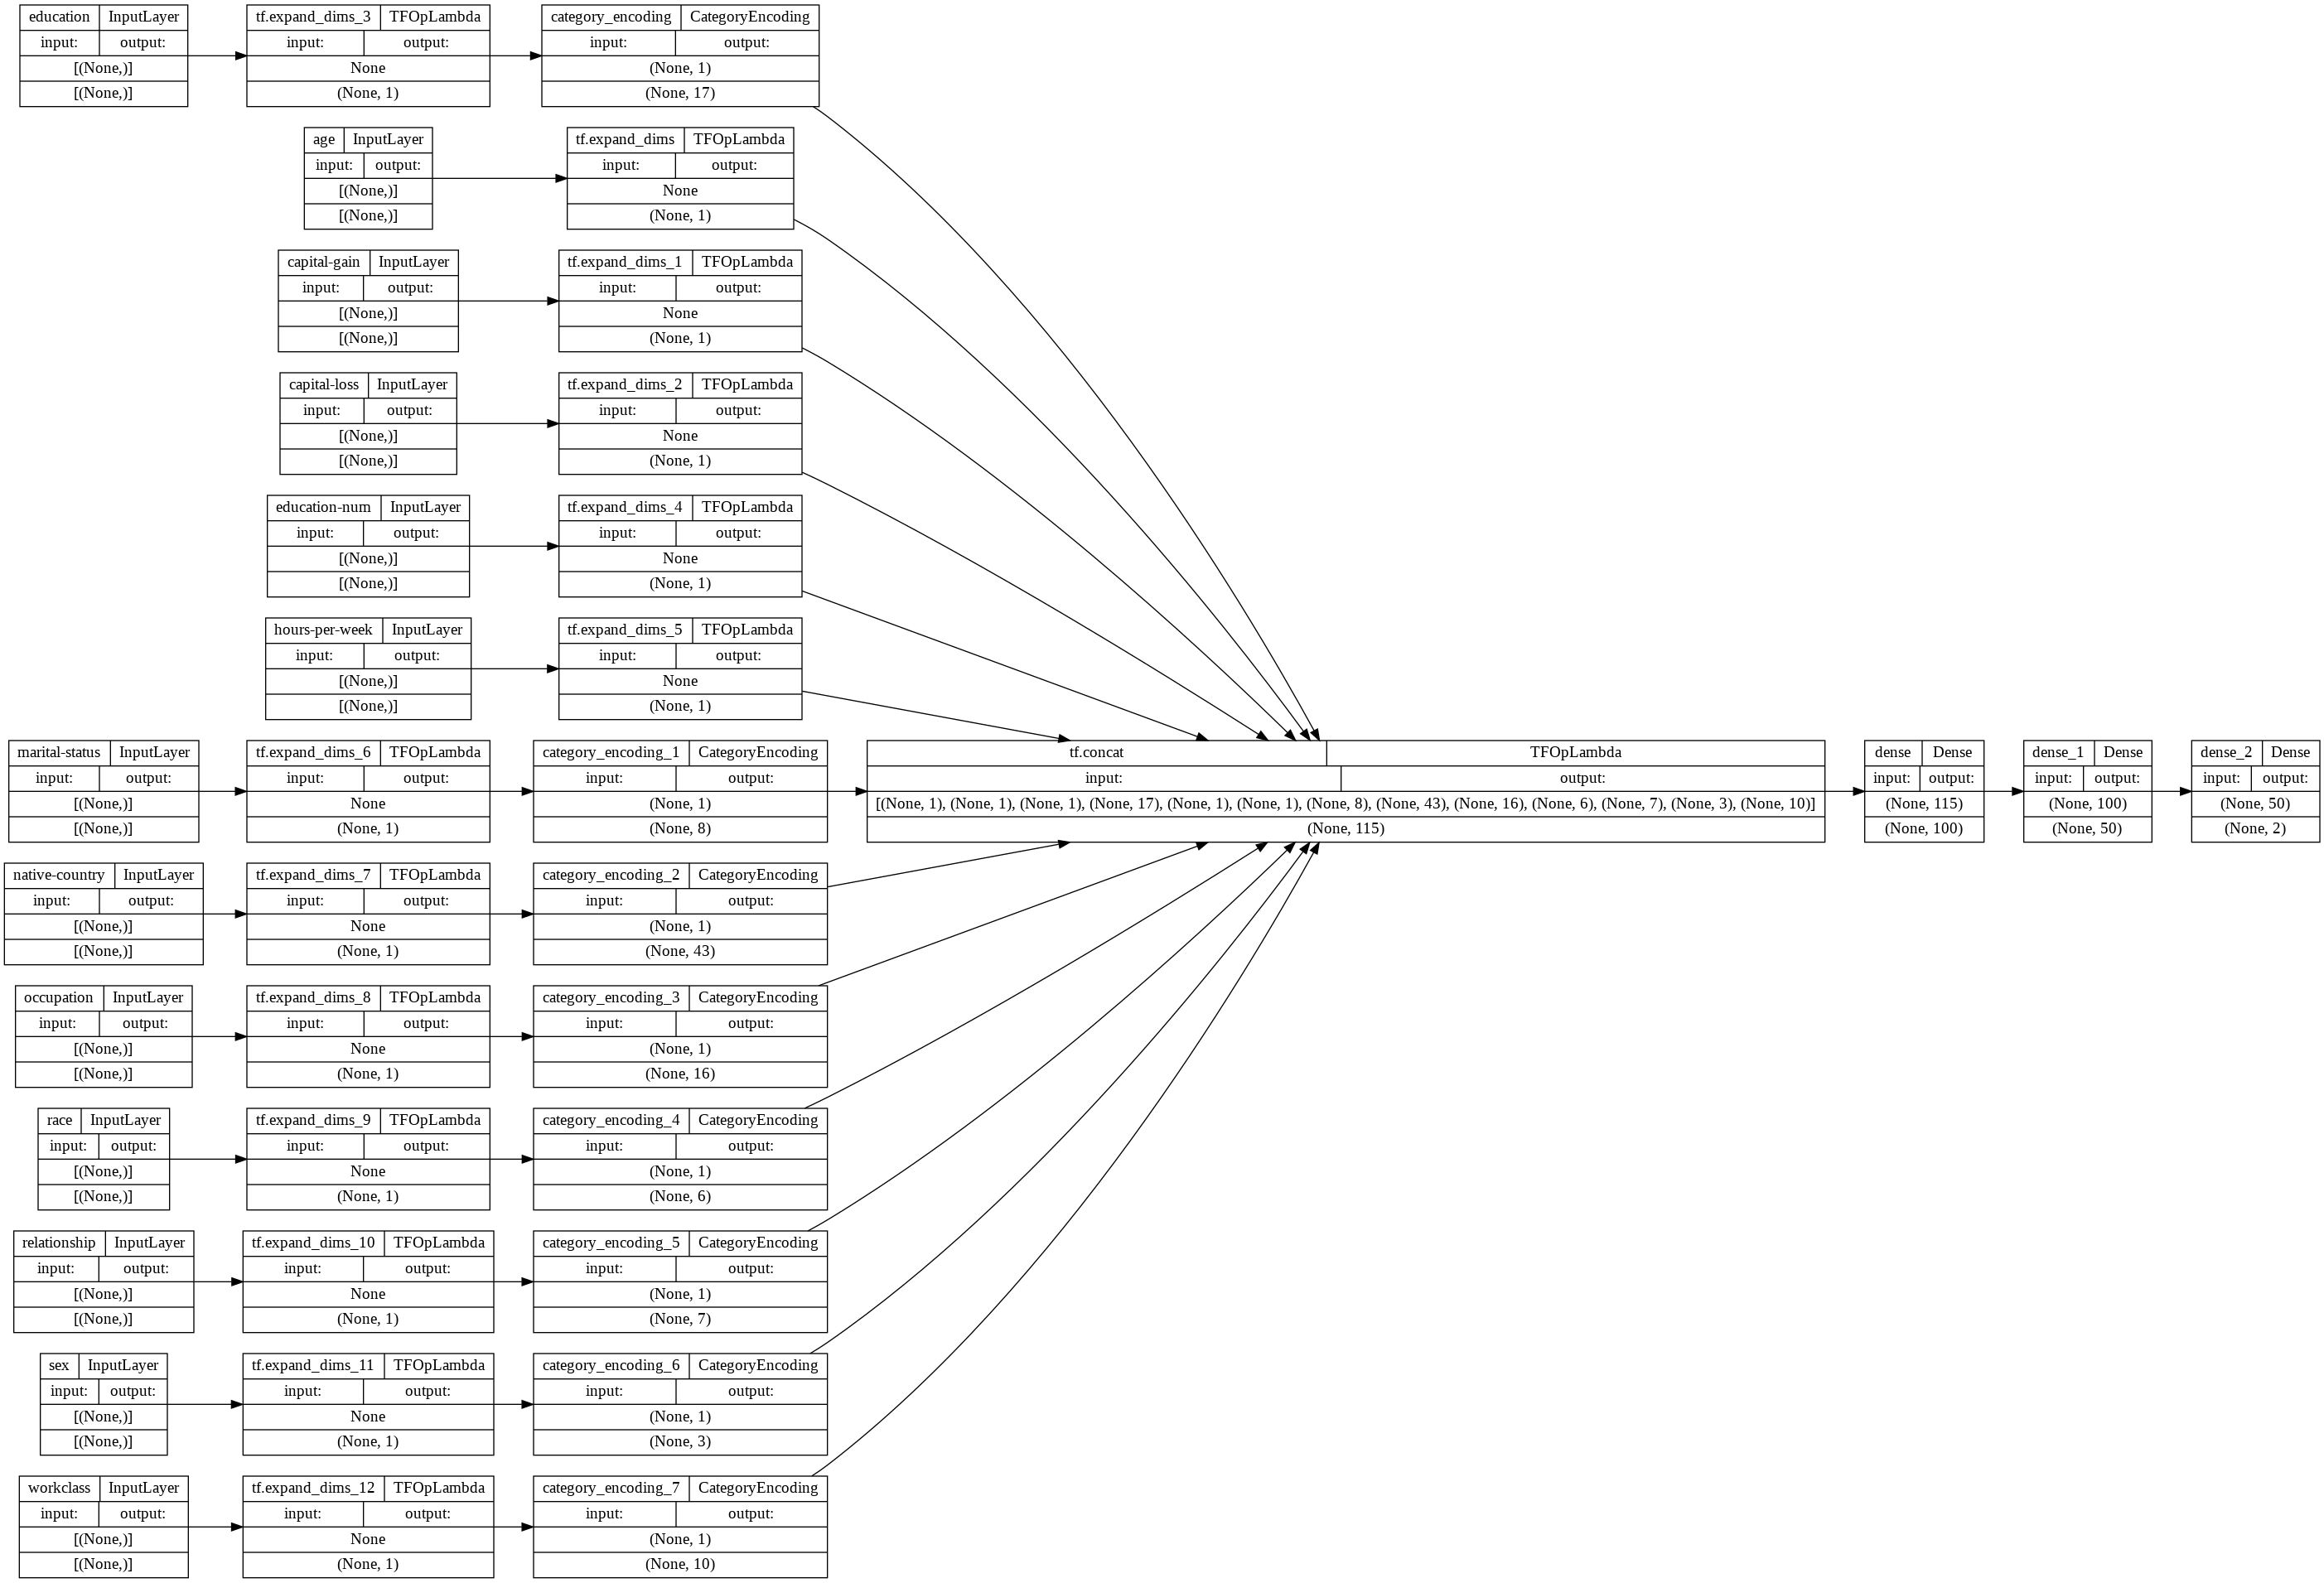

In [48]:
model = build_keras_model(output_dir)

tf.keras.utils.plot_model(model,rankdir='LR', show_shapes=True)

Build the datasets

In [49]:
def get_dataset(working_dir, filebase):
  tf_transform_output = tft.TFTransformOutput(working_dir)

  data_path_pattern = os.path.join(
      working_dir,
      filebase + '*')
  
  input_fn = _make_training_input_fn(
      tf_transform_output,
      data_path_pattern,
      batch_size=BATCH_SIZE)
  
  dataset = input_fn()

  return dataset

Train and evaluate the model:

In [50]:
def train_and_evaluate(
    model,
    working_dir):
  """Train the model on training data and evaluate on test data.

  Args:
    working_dir: The location of the Transform output.
    num_train_instances: Number of instances in train set
    num_test_instances: Number of instances in test set

  Returns:
    The results from the estimator's 'evaluate' method
  """
  train_dataset = get_dataset(working_dir, TRANSFORMED_TRAIN_DATA_FILEBASE)
  validation_dataset = get_dataset(working_dir, TRANSFORMED_TEST_DATA_FILEBASE)

  model = build_keras_model(working_dir)

  history = train_model(model, train_dataset, validation_dataset)

  metric_values = model.evaluate(validation_dataset,
                                 steps=EVALUATION_STEPS,
                                 return_dict=True)
  return model, history, metric_values

In [51]:
def train_model(model, train_dataset, validation_dataset):
  model.compile(optimizer='adam',
                loss=tf.losses.CategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  history = model.fit(train_dataset, validation_data=validation_dataset,
      epochs=TRAIN_NUM_EPOCHS,
      steps_per_epoch=STEPS_PER_TRAIN_EPOCH,
      validation_steps=EVALUATION_STEPS)
  return history

In [52]:
model, history, metric_values = train_and_evaluate(model, output_dir)

Epoch 1/20
26/26 [==============================] - 2s 46ms/step - loss: 0.5489 - accuracy: 0.7082 - val_loss: 0.4564 - val_accuracy: 0.7639
Epoch 2/20
26/26 [==============================] - 1s 31ms/step - loss: 0.4255 - accuracy: 0.7933 - val_loss: 0.3853 - val_accuracy: 0.8233
Epoch 3/20
26/26 [==============================] - 1s 31ms/step - loss: 0.3849 - accuracy: 0.8206 - val_loss: 0.3644 - val_accuracy: 0.8334
Epoch 4/20
26/26 [==============================] - 1s 31ms/step - loss: 0.3664 - accuracy: 0.8341 - val_loss: 0.3609 - val_accuracy: 0.8341
Epoch 5/20
26/26 [==============================] - 1s 32ms/step - loss: 0.3607 - accuracy: 0.8329 - val_loss: 0.3507 - val_accuracy: 0.8361
Epoch 6/20
26/26 [==============================] - 1s 31ms/step - loss: 0.3510 - accuracy: 0.8347 - val_loss: 0.3478 - val_accuracy: 0.8398
Epoch 7/20
26/26 [==============================] - 1s 32ms/step - loss: 0.3556 - accuracy: 0.8281 - val_loss: 0.3443 - val_accuracy: 0.8391
Epoch 8/20
26

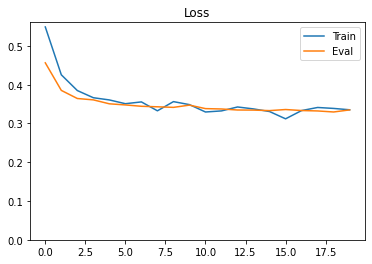

In [53]:
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Eval')
plt.ylim(0,max(plt.ylim()))
plt.legend()
plt.title('Loss');

### Transform new data

In the previous section the training process used the hard-copies of the transformed data that were generated by `tft_beam.AnalyzeAndTransformDataset` in the `transform_dataset` function. 

For operating on new data you'll need to load final version of the `preprocessing_fn` that was saved by `tft_beam.WriteTransformFn`. 

The `TFTransformOutput.transform_features_layer` method loads the `preprocessing_fn` SavedModel from the output directory.

Here's a function to load new, unprocessed batches from a source file:

In [54]:
def read_csv(file_name, batch_size):
  return tf.data.experimental.make_csv_dataset(
        file_pattern=file_name,
        batch_size=batch_size,
        column_names=ORDERED_CSV_COLUMNS,
        column_defaults=COLUMN_DEFAULTS,
        prefetch_buffer_size=0,
        ignore_errors=True)

In [55]:
for ex in read_csv(test_path, batch_size=5):
  break

pd.DataFrame(ex)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,label
0,23.0,b' Private',131415.0,b' HS-grad',9.0,b' Married-civ-spouse',b' Other-service',b' Wife',b' White',b' Female',0.0,0.0,35.0,b' United-States',b' <=50K.'
1,35.0,b' Local-gov',132879.0,b' HS-grad',9.0,b' Married-civ-spouse',b' Transport-moving',b' Husband',b' White',b' Male',0.0,0.0,40.0,b' United-States',b' <=50K.'
2,40.0,b' Private',132222.0,b' Masters',14.0,b' Married-civ-spouse',b' Prof-specialty',b' Husband',b' White',b' Male',0.0,0.0,50.0,b' United-States',b' <=50K.'
3,37.0,b' Self-emp-not-inc',183127.0,b' HS-grad',9.0,b' Divorced',b' Sales',b' Own-child',b' White',b' Female',0.0,0.0,40.0,b' United-States',b' <=50K.'
4,48.0,b' Private',95388.0,b' Some-college',10.0,b' Never-married',b' Exec-managerial',b' Not-in-family',b' Black',b' Female',0.0,0.0,40.0,b' United-States',b' <=50K.'


Load the `tft.TransformFeaturesLayer` to transform this data with the `preprocessing_fn`:

In [56]:
ex2 = ex.copy()
ex2.pop('fnlwgt')

tft_layer = tf_transform_output.transform_features_layer()
t_ex = tft_layer(ex2)

label = t_ex.pop(LABEL_KEY)
pd.DataFrame(t_ex)

INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


,education,race,age,capital-gain,hours-per-week,sex,marital-status,relationship,native-country,workclass,capital-loss,education-num,occupation
0,0,0,0.082192,0.0,0.346939,1,0,4,0,0,0.0,0.533333,5
1,0,0,0.246575,0.0,0.397959,0,0,0,0,2,0.0,0.533333,8
2,3,0,0.315068,0.0,0.500000,0,0,0,0,0,0.0,0.866667,0
3,0,0,0.273973,0.0,0.397959,1,2,2,0,1,0.0,0.533333,4
4,1,1,0.424658,0.0,0.397959,1,1,1,0,0,0.0,0.600000,2


The `tft_layer` is smart enough to still execute the transformation if only a subset of features are passed in. For example, if you only pass in two features, you'll get just the transformed versions of those features back: 

In [57]:
ex2 = pd.DataFrame(ex)[['education', 'hours-per-week']]
ex2

,education,hours-per-week
0,b' HS-grad',35.0
1,b' HS-grad',40.0
2,b' Masters',50.0
3,b' HS-grad',40.0
4,b' Some-college',40.0


In [58]:
pd.DataFrame(tft_layer(dict(ex2)))

,education,hours-per-week
0,0,0.346939
1,0,0.397959
2,3,0.500000
3,0,0.397959
4,1,0.397959


Here's a more robust version that drops features that are not in the feature-spec, and returns a `(features, label)` pair if the label is in the provided features:

In [59]:
class Transform(tf.Module):
  def __init__(self, working_dir):
    self.working_dir = working_dir
    self.tf_transform_output = tft.TFTransformOutput(working_dir)
    self.tft_layer = tf_transform_output.transform_features_layer()
  
  @tf.function
  def __call__(self, features):
    raw_features = {}

    for key, val in features.items():
      # Skip unused keys
      if key not in RAW_DATA_FEATURE_SPEC:
        continue

      raw_features[key] = val

    # Apply the `preprocessing_fn`.
    transformed_features = tft_layer(raw_features)
    
    if LABEL_KEY in transformed_features:
      # Pop the label and return a (features, labels) pair.
      data_labels = transformed_features.pop(LABEL_KEY)
      return (transformed_features, data_labels)
    else:
      return transformed_features


In [60]:
transform = Transform(output_dir)

In [61]:
t_ex, t_label = transform(ex)

In [62]:
pd.DataFrame(t_ex)

,education,race,age,capital-gain,hours-per-week,sex,marital-status,relationship,native-country,workclass,capital-loss,education-num,occupation
0,0,0,0.082192,0.0,0.346939,1,0,4,0,0,0.0,0.533333,5
1,0,0,0.246575,0.0,0.397959,0,0,0,0,2,0.0,0.533333,8
2,3,0,0.315068,0.0,0.500000,0,0,0,0,0,0.0,0.866667,0
3,0,0,0.273973,0.0,0.397959,1,2,2,0,1,0.0,0.533333,4
4,1,1,0.424658,0.0,0.397959,1,1,1,0,0,0.0,0.600000,2


Now you can use `Dataset.map` to apply that transformation, on the fly to new data:

In [63]:
model.evaluate(
    read_csv(test_path, batch_size=5).map(transform),
    steps=EVALUATION_STEPS,
    return_dict=True
)

128/128 [==============================] - 1s 5ms/step - loss: 0.3117 - accuracy: 0.8656


{'accuracy': 0.8656250238418579, 'loss': 0.31166619062423706}

### Export the model

So you have a trained model, and a method to apply the `preporcessing_fn` to new data. Assemble them into a new model that accepts serialized `tf.train.Example` protos as input.

In [64]:
class ServingModel(tf.Module):
  def __init__(self, model, working_dir):
    self.model = model
    self.working_dir = working_dir
    self.transform = Transform(working_dir)

  @tf.function(input_signature=[tf.TensorSpec(shape=[None], dtype=tf.string)])
  def __call__(self, serialized_tf_examples):
    # parse the tf.train.Example
    feature_spec = RAW_DATA_FEATURE_SPEC.copy()
    feature_spec.pop(LABEL_KEY)
    parsed_features = tf.io.parse_example(serialized_tf_examples, feature_spec)
    # Apply the `preprocessing_fn`
    transformed_features = self.transform(parsed_features)
    # Run the model
    outputs = self.model(transformed_features)
    # Format the output
    classes_names = tf.constant([['0', '1']])
    classes = tf.tile(classes_names, [tf.shape(outputs)[0], 1])
    return {'classes': classes, 'scores': outputs}

  def export(self, output_dir):
    # Increment the directory number. This is required in order to make this
    # model servable with model_server.
    save_model_dir = pathlib.Path(output_dir)/'model'
    number_dirs = [int(p.name) for p in save_model_dir.glob('*')
                  if p.name.isdigit()]
    id = max([0] + number_dirs)+1
    save_model_dir = save_model_dir/str(id)

    # Set the signature to make it visible for serving.
    concrete_serving_fn = self.__call__.get_concrete_function()
    signatures = {'serving_default': concrete_serving_fn}

    # Export the model.
    tf.saved_model.save(
        self,
        str(save_model_dir),
        signatures=signatures)
    
    return save_model_dir

In [66]:
output_dir

'/tmp/tmpins2gs52/keras'

Build the model and test-run it on the batch of serialized examples:

In [65]:
serving_model = ServingModel(model, output_dir)

serving_model(serialized_example_batch)

{'classes': <tf.Tensor: shape=(3, 2), dtype=string, numpy=
 array([[b'0', b'1'],
        [b'0', b'1'],
        [b'0', b'1']], dtype=object)>,
 'scores': <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[-1.3698443,  1.5338743],
        [-0.3661482,  0.3261491],
        [-1.9847808,  1.8497629]], dtype=float32)>}

Export the model as a SavedModel:

In [67]:
saved_model_dir = serving_model.export(output_dir)
saved_model_dir

INFO:tensorflow:Assets written to: /tmp/tmpins2gs52/keras/model/1/assets


INFO:tensorflow:Assets written to: /tmp/tmpins2gs52/keras/model/1/assets


PosixPath('/tmp/tmpins2gs52/keras/model/1')

Reload the the model and test it on the same batch of examples:

In [68]:
reloaded = tf.saved_model.load(str(saved_model_dir))
run_model = reloaded.signatures['serving_default']

In [69]:
run_model(serialized_example_batch)

{'classes': <tf.Tensor: shape=(3, 2), dtype=string, numpy=
 array([[b'0', b'1'],
        [b'0', b'1'],
        [b'0', b'1']], dtype=object)>,
 'scores': <tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[-1.3698443,  1.5338743],
        [-0.3661482,  0.3261491],
        [-1.9847808,  1.8497629]], dtype=float32)>}

##What we did
In this example we used `tf.Transform` to preprocess a dataset of census data, and train a model with the cleaned and transformed data.  We also created an input function that we could use when we deploy our trained model in a production environment to perform inference.  By using the same code for both training and inference we avoid any issues with data skew.  Along the way we learned about creating an Apache Beam transform to perform the transformation that we needed for cleaning the data. We also saw how to use this transformed data to train a model using `tf.keras`.  This is just a small piece of what TensorFlow Transform can do!  We encourage you to dive into `tf.Transform` and discover what it can do for you.

## [Optional] Using our preprocessed data to train a model using tf.estimator

> Warning: Estimators are not recommended for new code.  Estimators run
<a href="https://www.tensorflow.org/api_docs/python/tf/compat/v1/Session"><code>v1.Session</code></a>-style code which is more difficult to write correctly, and
can behave unexpectedly, especially when combined with TF 2 code. Estimators
do fall under our
[compatibility guarantees](https://tensorflow.org/guide/versions), but will
receive no fixes other than security vulnerabilities. See the
[migration guide](https://tensorflow.org/guide/migrate) for details.

 <!-- <div class="tfo-display-only-on-site"><devsite-expandable>
  <button type="button" class="button-red button expand-control">Show Section</button> -->


###Create an input function for training

In [ ]:
def _make_training_input_fn(tf_transform_output, transformed_examples,
                            batch_size):
  """Creates an input function reading from transformed data.

  Args:
    tf_transform_output: Wrapper around output of tf.Transform.
    transformed_examples: Base filename of examples.
    batch_size: Batch size.

  Returns:
    The input function for training or eval.
  """
  def input_fn():
    """Input function for training and eval."""
    dataset = tf.data.experimental.make_batched_features_dataset(
        file_pattern=transformed_examples,
        batch_size=batch_size,
        features=tf_transform_output.transformed_feature_spec(),
        reader=tf.data.TFRecordDataset,
        shuffle=True)

    transformed_features = tf.compat.v1.data.make_one_shot_iterator(
        dataset).get_next()

    # Extract features and label from the transformed tensors.
    transformed_labels = tf.where(
        tf.equal(transformed_features.pop(LABEL_KEY), 1))

    return transformed_features, transformed_labels[:,1]

  return input_fn

###Create an input function for serving

Let's create an input function that we could use in production, and prepare our trained model for serving.

In [ ]:
def _make_serving_input_fn(tf_transform_output):
  """Creates an input function reading from raw data.

  Args:
    tf_transform_output: Wrapper around output of tf.Transform.

  Returns:
    The serving input function.
  """
  raw_feature_spec = RAW_DATA_FEATURE_SPEC.copy()
  # Remove label since it is not available during serving.
  raw_feature_spec.pop(LABEL_KEY)

  def serving_input_fn():
    """Input function for serving."""
    # Get raw features by generating the basic serving input_fn and calling it.
    # Here we generate an input_fn that expects a parsed Example proto to be fed
    # to the model at serving time.  See also
    # tf.estimator.export.build_raw_serving_input_receiver_fn.
    raw_input_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(
        raw_feature_spec, default_batch_size=None)
    serving_input_receiver = raw_input_fn()

    # Apply the transform function that was used to generate the materialized
    # data.
    raw_features = serving_input_receiver.features
    transformed_features = tf_transform_output.transform_raw_features(
        raw_features)

    return tf.estimator.export.ServingInputReceiver(
        transformed_features, serving_input_receiver.receiver_tensors)

  return serving_input_fn

###Wrap our input data in FeatureColumns
Our model will expect our data in TensorFlow FeatureColumns.

In [ ]:
def get_feature_columns(tf_transform_output):
  """Returns the FeatureColumns for the model.

  Args:
    tf_transform_output: A `TFTransformOutput` object.

  Returns:
    A list of FeatureColumns.
  """
  # Wrap scalars as real valued columns.
  real_valued_columns = [tf.feature_column.numeric_column(key, shape=())
                         for key in NUMERIC_FEATURE_KEYS]

  # Wrap categorical columns.
  one_hot_columns = [
      tf.feature_column.indicator_column(
          tf.feature_column.categorical_column_with_identity(
              key=key,
              num_buckets=(NUM_OOV_BUCKETS +
                  tf_transform_output.vocabulary_size_by_name(
                      vocab_filename=key))))
      for key in CATEGORICAL_FEATURE_KEYS]

  return real_valued_columns + one_hot_columns

###Train, Evaluate, and Export our model

In [ ]:
def train_and_evaluate(working_dir, num_train_instances=NUM_TRAIN_INSTANCES,
                       num_test_instances=NUM_TEST_INSTANCES):
  """Train the model on training data and evaluate on test data.

  Args:
    working_dir: Directory to read transformed data and metadata from and to
        write exported model to.
    num_train_instances: Number of instances in train set
    num_test_instances: Number of instances in test set

  Returns:
    The results from the estimator's 'evaluate' method
  """
  tf_transform_output = tft.TFTransformOutput(working_dir)

  run_config = tf.estimator.RunConfig()

  estimator = tf.estimator.LinearClassifier(
      feature_columns=get_feature_columns(tf_transform_output),
      config=run_config,
      loss_reduction=tf.losses.Reduction.SUM)

  # Fit the model using the default optimizer.
  train_input_fn = _make_training_input_fn(
      tf_transform_output,
      os.path.join(working_dir, TRANSFORMED_TRAIN_DATA_FILEBASE + '*'),
      batch_size=BATCH_SIZE)
  estimator.train(
      input_fn=train_input_fn,
      max_steps=TRAIN_NUM_EPOCHS * num_train_instances / BATCH_SIZE)

  # Evaluate model on test dataset.
  eval_input_fn = _make_training_input_fn(
      tf_transform_output,
      os.path.join(working_dir, TRANSFORMED_TEST_DATA_FILEBASE + '*'),
      batch_size=1)

  # Export the model.
  serving_input_fn = _make_serving_input_fn(tf_transform_output)
  exported_model_dir = os.path.join(working_dir, EXPORTED_MODEL_DIR)
  estimator.export_saved_model(exported_model_dir, serving_input_fn)

  return estimator.evaluate(input_fn=eval_input_fn, steps=num_test_instances)

###Put it all together
We've created all the stuff we need to preprocess our census data, train a model, and prepare it for serving.  So far we've just been getting things ready.  It's time to start running!

Note: Scroll the output from this cell to see the whole process.  The results will be at the bottom.

In [ ]:
import tempfile
temp = temp = os.path.join(tempfile.mkdtemp(),'estimator')

transform_data(train_path, test_path, temp)
results = train_and_evaluate(temp)

In [ ]:
pprint.pprint(results)

 </devsite-expandable></div>
